In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import gc
import swifter
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import gensim
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import sklearn 
import gensim
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pyLDAvis.enable_notebook()

In [3]:
df_narr = pd.read_csv('/Volumes/GoogleDrive/My Drive/Spring/practicum/narratives.csv')

In [4]:
narr_file_read = pd.read_csv('/Volumes/GoogleDrive/My Drive/Spring/practicum/narratives.csv', usecols=['Consumer complaint narrative'], converters={'Consumer complaint narrative': eval}, chunksize=10000, iterator=True)
stringed = pd.Series(dtype='string')

for chunk in tqdm(narr_file_read):
    stringed = stringed.append(chunk['Consumer complaint narrative'].swifter.progress_bar(False).apply(lambda x: [' '.join(x)]))

In [5]:
stringed = pd.Series([string[0] for string in stringed])

In [24]:
for sentence in stringed.values:
    print(sentence)
    print(type(sentence))
    break

transworld system inc try collect debt mine owe inaccurate
<class 'str'>


In [6]:
df_narr['Consumer complaint narrative'] = stringed.values

In [7]:
del stringed
del chunk
gc.collect()

203

In [27]:
df_narr['Consumer complaint narrative'].iloc[100]

'hi send letter deliver request information report error response receive back company disheartening feel like take advantage company credit bureau go month try fix issue everyone simply ignore disregard request letter send clearly state exactly need prove information may report error however simply reply back state request anything specific prove claim attach letter send request inside letter also response letter come month half later company reputation illegal loan shark transaction account set ridiculous late fee billing cycle set increase likelihood miss payment wit end situation need resolve immediately'

#Topic Prevalance over time

### Computing Topic Prevalence

In [9]:
doc_topic_dist=np.load('/Volumes/GoogleDrive/My Drive/Spring/practicum/doc_topic_dist.npy')

In [10]:
doc_topic_dist

array([[0.02606542, 0.02608642, 0.02606826, ..., 0.48421719, 0.02606972,
        0.02606551],
       [0.01769284, 0.01769644, 0.01770169, ..., 0.01771046, 0.01769674,
        0.01769293],
       [0.01535443, 0.01535827, 0.01535894, ..., 0.55257739, 0.01535494,
        0.01535456],
       ...,
       [0.01227167, 0.01227314, 0.01227324, ..., 0.01227543, 0.01227374,
        0.02738085],
       [0.0272792 , 0.02727985, 0.02728058, ..., 0.02729499, 0.02727946,
        0.02729107],
       [0.01504453, 0.01504848, 0.01505042, ..., 0.01504837, 0.01504671,
        0.01504483]])

In [11]:
df_topic = pd.DataFrame(doc_topic_dist).idxmax(axis=1)
#identify topic 

In [13]:
df_prob = pd.DataFrame(doc_topic_dist).max(axis=1)
#identify probability

In [14]:
date_rec = df_narr['Date received']

In [16]:
df_max_topics = pd.concat([df_topic, df_prob, date_rec], axis = 1)

df_max_topics.columns =['Topic', 'max_prob', 'date_rec'] 

In [19]:
df_max_topics['date_rec'] = pd.to_datetime(df_max_topics['date_rec'])
df_max_topics['year'] = pd.DatetimeIndex(df_max_topics['date_rec']).year

In [27]:
total = df_max_topics.groupby('year').agg({'Topic':'count'}).reset_index()
total.columns = ['year','total_docs']
total
#total count of documents per year

,year,total_docs
0,2015,54751
1,2016,77819
2,2017,115171
3,2018,118480
4,2019,124790
5,2020,164020
6,2021,2688


In [36]:
maxcount = df_max_topics.groupby(['year','Topic']).agg({'max_prob':'count'}).reset_index()
maxcount.columns = ['year', 'Topic', 'Max_Count']
maxcount
#count of documents per topic per year

,year,Topic,Max_Count
0,2015,0,7
1,2015,1,724
2,2015,2,2159
3,2015,3,232
4,2015,4,37430
...,...,...,...
65,2021,5,884
66,2021,6,8
67,2021,7,343
68,2021,8,16


In [37]:
max_counts = maxcount.merge(total, on='year', how='left')
max_counts

,year,Topic,Max_Count,total_docs
0,2015,0,7,54751
1,2015,1,724,54751
2,2015,2,2159,54751
3,2015,3,232,54751
4,2015,4,37430,54751
...,...,...,...,...
65,2021,5,884,2688
66,2021,6,8,2688
67,2021,7,343,2688
68,2021,8,16,2688


In [38]:
max_counts['prevalence'] = max_counts['Max_Count']/max_counts['total_docs']
max_counts

,year,Topic,Max_Count,total_docs,prevalence
0,2015,0,7,54751,0.000128
1,2015,1,724,54751,0.013224
2,2015,2,2159,54751,0.039433
3,2015,3,232,54751,0.004237
4,2015,4,37430,54751,0.683640
...,...,...,...,...,...
65,2021,5,884,2688,0.328869
66,2021,6,8,2688,0.002976
67,2021,7,343,2688,0.127604
68,2021,8,16,2688,0.005952


In [40]:
topic_words = pickle.load( open('/Volumes/GoogleDrive/My Drive/Spring/practicum/lda_topic_keywords.pkl','rb'))

In [49]:
words_df = pd.DataFrame(topic_words)
words_df = words_df.iloc[:,0:5]
words_df1 = words_df.apply(lambda x: ', '.join(x), axis=1).reset_index()
words_df1.columns = ['Topic', 'Words']
words_df1
#top five words per topic

,Topic,Words
0,0,"ditech, insurance, navy, union, repossession"
1,1,"account, report, credit, open, mine"
2,2,"credit, report, inquiry, remove, account"
3,3,"theft, identity, victim, block, fraudulent"
4,4,"payment, loan, account, pay, call"
5,5,"report, account, credit, information, dispute"
6,6,"call, number, phone, stop, social"
7,7,"debt, collection, report, credit, account"
8,8,"late, report, usaa, understanding, mistake"
9,9,"loan, student, school, deferment, education"


In [50]:
max_counts = max_counts.merge(words_df1, on="Topic")
max_counts

,year,Topic,Max_Count,total_docs,prevalence,Words
0,2015,0,7,54751,0.000128,"ditech, insurance, navy, union, repossession"
1,2016,0,6,77819,0.000077,"ditech, insurance, navy, union, repossession"
2,2017,0,26,115171,0.000226,"ditech, insurance, navy, union, repossession"
3,2018,0,13,118480,0.000110,"ditech, insurance, navy, union, repossession"
4,2019,0,31,124790,0.000248,"ditech, insurance, navy, union, repossession"
...,...,...,...,...,...,...
65,2017,9,72,115171,0.000625,"loan, student, school, deferment, education"
66,2018,9,61,118480,0.000515,"loan, student, school, deferment, education"
67,2019,9,52,124790,0.000417,"loan, student, school, deferment, education"
68,2020,9,60,164020,0.000366,"loan, student, school, deferment, education"


Text(0.5, 0.98, 'Percentage of Documents where Topic is Most Significant per Year')

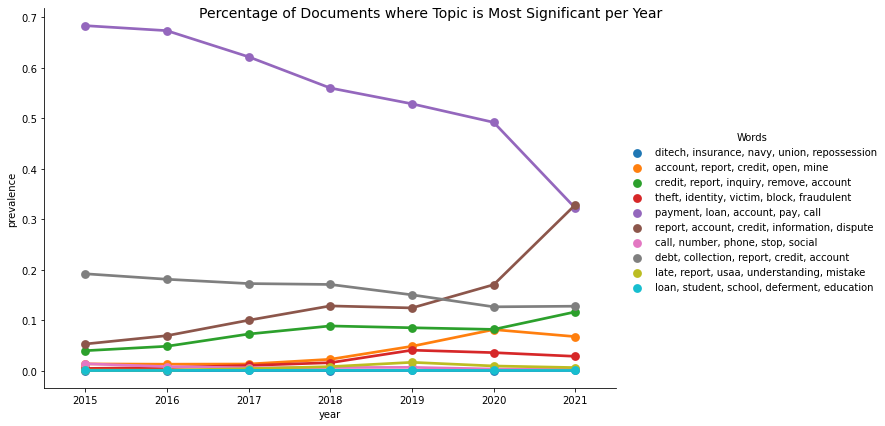

In [78]:
p = sns.factorplot(data=max_counts, x="year", y='prevalence', kind='point', hue='Words', col_wrap=None, 
                   size=6, aspect=1.5)
p.fig.suptitle('Percentage of Documents where Topic is Most Significant per Year', fontsize=14)
    

### Normalizing Weights to Proportion of Total

In [71]:
topic_dis = pd.DataFrame(doc_topic_dist).reset_index()
topic_dis.rename(columns={'index':'doc_id'}, inplace=True)
topic_dis = topic_dis.melt(id_vars=['doc_id'], 
        var_name="Topic", 
        value_name="Topic_prob")
#probabilities of each topic of each document

In [72]:
docyears = df_max_topics[['year']].reset_index()
docyears.rename(columns={'index':'doc_id'}, inplace=True)
topic_dis = topic_dis.merge(docyears, on='doc_id', how='left')
topic_dis

,doc_id,Topic,Topic_prob,year
0,0,0,0.026065,2019
1,1,0,0.017693,2019
2,2,0,0.015354,2019
3,3,0,0.015017,2019
4,4,0,0.012220,2019
...,...,...,...,...
6577185,657714,9,0.015794,2016
6577186,657715,9,0.015324,2017
6577187,657716,9,0.027381,2015
6577188,657717,9,0.027291,2015


In [80]:
y_df = topic_dis.groupby(['year', 'Topic']).agg({'Topic_prob': 'sum'})
ny_df = y_df.groupby(level=0).apply(lambda x: x / x.sum()).reset_index()
ny_df.columns = ['year', 'Topic', 'Normalized_weight']
ny_df = ny_df.merge(words_df1, on="Topic")
ny_df
#aggregate probabilities - sum up all of the values for each topic in a given time frame
#normalize those values by dividing by the sum of all the weights in that period
#proportion of the total weight held by each individual topic 

,year,Topic,Normalized_weight,Words
0,2015,0,0.020336,"ditech, insurance, navy, union, repossession"
1,2016,0,0.020412,"ditech, insurance, navy, union, repossession"
2,2017,0,0.019435,"ditech, insurance, navy, union, repossession"
3,2018,0,0.019493,"ditech, insurance, navy, union, repossession"
4,2019,0,0.020609,"ditech, insurance, navy, union, repossession"
...,...,...,...,...
65,2017,9,0.022699,"loan, student, school, deferment, education"
66,2018,9,0.021532,"loan, student, school, deferment, education"
67,2019,9,0.021717,"loan, student, school, deferment, education"
68,2020,9,0.022196,"loan, student, school, deferment, education"


Text(0.5, 0.98, 'Proportion of Total Topic Weight by Topic per year')

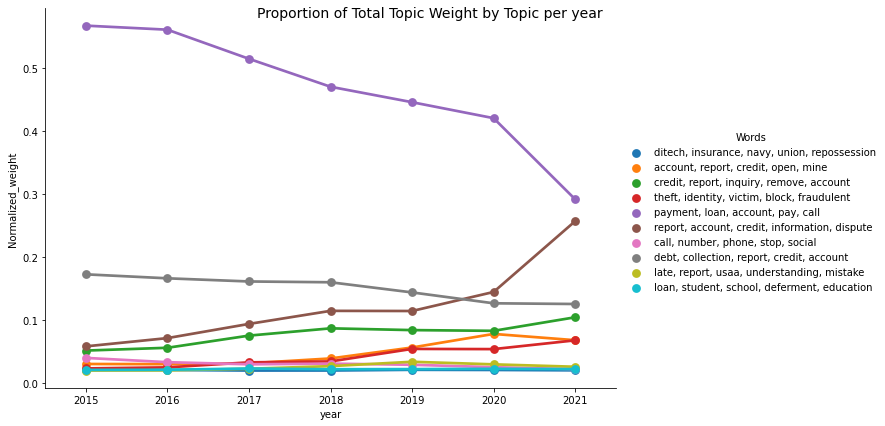

In [81]:
p1 = sns.factorplot(data=ny_df, x="year", y='Normalized_weight', kind='point', hue='Words', col_wrap=None, 
                   size=6, aspect=1.5)
p1.fig.suptitle('Proportion of Total Topic Weight by Topic per year', fontsize=14)